# 03 - Modelo de Clasificación: Regresión Logística

En este notebook entrenaremos y evaluaremos un modelo de **Regresión Logística**,  
que servirá como línea base (*baseline model*) para comparar con otros algoritmos de clasificación.

### 🎯 Objetivos:
- Cargar los datasets procesados (escalados y no escalados).
- Entrenar el modelo de **Logistic Regression**.
- Aplicar **validación cruzada (cross-validation)**.
- Realizar **tuning de hiperparámetros** mediante `GridSearchCV`.
- Evaluar el rendimiento con métricas de clasificación y gráficas interpretativas.

## **Paso 1: Carga de datasets**

El modelo de Regresión Logística es **sensible a la escala de las variables**,  
por lo que utilizaremos el dataset **escalado** generado en el notebook `02_dataset-split.ipynb`.


In [140]:
# ===================================
# 1. Import librerías y carga de datasets escalados  
# ===================================

# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import json

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    make_scorer, confusion_matrix, RocCurveDisplay
)
from sklearn.metrics import classification_report
from IPython.display import display, Markdown
from sklearn.preprocessing import label_binarize





# Estilo de gráficos
plt.style.use('default')
sns.set_palette("Set2")

# Cargar datasets escalados
X_train = pd.read_csv("../data/processed/X_train_scaled.csv")
X_test = pd.read_csv("../data/processed/X_test_scaled.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").squeeze()
y_test = pd.read_csv("../data/processed/y_test.csv").squeeze()

print("✅ Datasets cargados correctamente.")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")


✅ Datasets cargados correctamente.
X_train: (83123, 23), X_test: (20781, 23)


## **Paso 2: Entrenamiento del modelo base**

Entrenamos un modelo de **Regresión Logística sin ajustar hiperparámetros**  (usamos hiperparámetros por defecto)
para establecer una línea base de rendimiento.

Este modelo servirá como punto de referencia antes de aplicar técnicas de optimización y ajuste.  

El objetivo es evaluar el rendimiento inicial del modelo en el conjunto de test  
y obtener las métricas principales (*Accuracy*, *F1-score* y *ROC-AUC*).


In [141]:
# ===================================
# 2. Entrenamiento del modelo base
# ===================================


# Instanciar el modelo base
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Entrenar el modelo
log_reg.fit(X_train, y_train)

# Predicciones
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Evaluación inicial
acc = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, pos_label=1)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"✅ Accuracy: {acc:.3f}")
print(f"✅ F1-score: {f1:.3f}")
print(f"✅ ROC-AUC: {roc_auc:.3f}")

# --- Comentario visual debajo del bloque ---
display(Markdown(
f"""
**💬 Interpretación de los resultados del modelo base:**

- **Accuracy ({acc:.3f})** indica la proporción total de predicciones correctas.  
- **F1-score ({f1:.3f})** combina *precision* y *recall*, útil si el dataset está desbalanceado.  
- **ROC-AUC ({roc_auc:.3f})** refleja la capacidad del modelo para distinguir entre clases (*satisfecho* vs *insatisfecho*).  

Estos valores servirán como referencia para comparar el impacto del tuning  
y las técnicas de mejora en pasos posteriores.
"""
))

✅ Accuracy: 0.877
✅ F1-score: 0.856
✅ ROC-AUC: 0.928



**💬 Interpretación de los resultados del modelo base:**

- **Accuracy (0.877)** indica la proporción total de predicciones correctas.  
- **F1-score (0.856)** combina *precision* y *recall*, útil si el dataset está desbalanceado.  
- **ROC-AUC (0.928)** refleja la capacidad del modelo para distinguir entre clases (*satisfecho* vs *insatisfecho*).  

Estos valores servirán como referencia para comparar el impacto del tuning  
y las técnicas de mejora en pasos posteriores.


## **Paso 3: Validación cruzada (Cross-Validation)**

Aplicamos validación cruzada para comprobar la estabilidad del modelo  
y evitar sobreajuste al conjunto de entrenamiento.

### Visualización de los resultados de la validación cruzada

Para analizar la estabilidad del modelo, representamos gráficamente los valores del F1-score  
obtenidos en cada una de las 5 particiones (folds) de la validación cruzada.
Esto nos permite evaluar la **consistencia del modelo** y su capacidad de generalización.  

Un modelo robusto o estable mostrará **valores de F1 similares entre los folds**,  
lo que indica que generaliza bien y no depende en exceso de un subconjunto específico de datos, mientras que un modelo inestable presentará variaciones amplias.




### Validación cruzada (Cross-Validation)

Para estimar la capacidad de generalización del modelo, aplicamos **validación cruzada (5-fold)**  
utilizando el **F1-score** como métrica de evaluación.  

Esto permite evaluar el modelo en diferentes subconjuntos del conjunto de entrenamiento,  
detectando posibles problemas de sobreajuste o inestabilidad.


📊 Resultados de la validación cruzada (F1 por fold):
Fold 1: 0.851
Fold 2: 0.854
Fold 3: 0.849
Fold 4: 0.854
Fold 5: 0.856

F1 promedio (CV): 0.853 ± 0.003


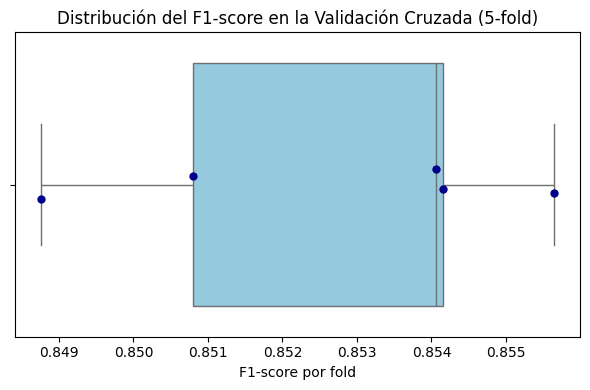


**💬 Interpretación visual:**

- Cada punto representa el **F1-score** obtenido en uno de los 5 folds.  
- Si los valores están muy próximos (caja estrecha y puntos agrupados),  
  el modelo es **consistente y generaliza bien**.  
- Si hay mucha dispersión, el modelo puede ser **inestable o sensible a los datos**.  
- El valor medio del F1-score (línea central de la caja) resume el rendimiento global del modelo en validación cruzada.


In [142]:
# ===================================
# 3. Validación cruzada (Cross-Validation)
# ===================================


# --- Markdown explicativo ---
display(Markdown(
"""
### Validación cruzada (Cross-Validation)

Para estimar la capacidad de generalización del modelo, aplicamos **validación cruzada (5-fold)**  
utilizando el **F1-score** como métrica de evaluación.  

Esto permite evaluar el modelo en diferentes subconjuntos del conjunto de entrenamiento,  
detectando posibles problemas de sobreajuste o inestabilidad.
"""
))

# --- Definimos un scorer F1 indicando la clase positiva ---
# --- La clase positiva (1) representa pasajeros satisfechos. ---
f1_scorer = make_scorer(f1_score, pos_label=1)

# --- Validación cruzada (5-fold) ---
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring=f1_scorer, n_jobs=-1)

# --- Resultados numéricos ---
print("📊 Resultados de la validación cruzada (F1 por fold):")
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: {score:.3f}")
print(f"\nF1 promedio (CV): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# --- Visualización de los F1 obtenidos en cada fold ---
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=cv_scores, color="skyblue", ax=ax)
sns.stripplot(x=cv_scores, color="darkblue", jitter=0.05, size=6, ax=ax)
ax.set_title("Distribución del F1-score en la Validación Cruzada (5-fold)", fontsize=12)
ax.set_xlabel("F1-score por fold")
plt.tight_layout()
plt.show()

# --- Comentario visual en Markdown debajo del gráfico ---
display(Markdown(
"""
**💬 Interpretación visual:**

- Cada punto representa el **F1-score** obtenido en uno de los 5 folds.  
- Si los valores están muy próximos (caja estrecha y puntos agrupados),  
  el modelo es **consistente y generaliza bien**.  
- Si hay mucha dispersión, el modelo puede ser **inestable o sensible a los datos**.  
- El valor medio del F1-score (línea central de la caja) resume el rendimiento global del modelo en validación cruzada.
"""
))


## **Paso 4: Tuning de hiperparámetros con GridSearchCV**

Se optimizan los parámetros principales de la Regresión Logística:

- `C`: controla la regularización (menor valor → mayor penalización).  
- `penalty`: tipo de regularización (`l2`).  
- `solver`: método de optimización compatible con la penalización elegida.



### 4️⃣ Tuning de hiperparámetros con GridSearchCV

En este paso buscamos la mejor combinación de hiperparámetros para la **Regresión Logística**  
optimizando el **F1-score** (ya que el dataset presenta cierto desbalanceo).

Usamos validación cruzada (5-fold) para evaluar múltiples combinaciones de:
- `C`: fuerza de regularización inversa (valores altos → menor regularización).  
- `solver`: algoritmo de optimización (`lbfgs` y `liblinear`).  
- `penalty`: tipo de regularización (`l2` en este caso).  

Además, aplicamos `class_weight="balanced"` para compensar el desbalanceo entre clases.


Fitting 5 folds for each of 10 candidates, totalling 50 fits
✅ GridSearch finalizado correctamente.
Mejor combinación de hiperparámetros: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor F1-score medio (CV): 0.850


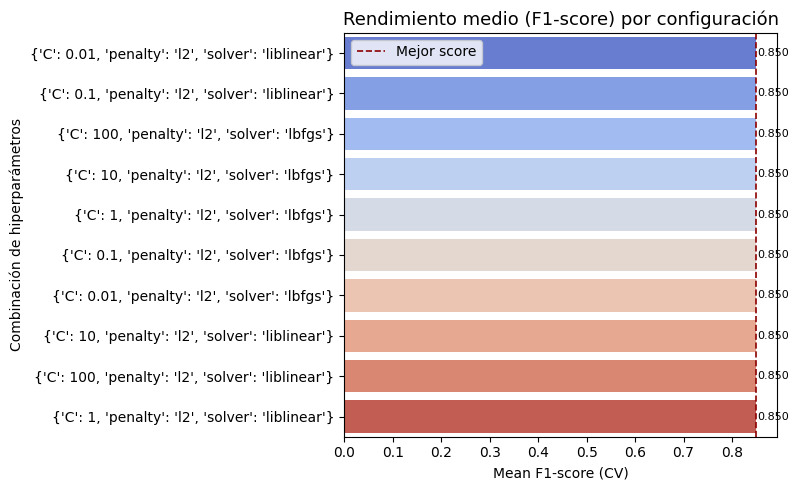


**💬 Interpretación del tuning de hiperparámetros:**

- Cada barra representa el **F1-score medio** obtenido por una combinación de hiperparámetros tras validación cruzada.  
- La **línea discontinua roja** indica el mejor rendimiento alcanzado (`best_score_`).  
- Las barras con valores similares indican que el modelo es **estable** y no muy sensible a pequeñas variaciones de parámetros.  
- En este caso, el parámetro `C` óptimo y el `solver` seleccionado ofrecen el mejor equilibrio entre **precisión y recall**.  


In [143]:
# ===================================
# 4. Tuning de hiperparámetros con GridSearchCV
# ===================================

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from IPython.display import display, Markdown
import warnings

# --- Markdown explicativo ---
display(Markdown(
"""
### 4️⃣ Tuning de hiperparámetros con GridSearchCV

En este paso buscamos la mejor combinación de hiperparámetros para la **Regresión Logística**  
optimizando el **F1-score** (ya que el dataset presenta cierto desbalanceo).

Usamos validación cruzada (5-fold) para evaluar múltiples combinaciones de:
- `C`: fuerza de regularización inversa (valores altos → menor regularización).  
- `solver`: algoritmo de optimización (`lbfgs` y `liblinear`).  
- `penalty`: tipo de regularización (`l2` en este caso).  

Además, aplicamos `class_weight="balanced"` para compensar el desbalanceo entre clases.
"""
))

# --- Control de warnings ---
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# --- Scorer personalizado (clase positiva = 1 que equivale a la variable satisfaction como "satisfied") ---
# --- Recordar que la bariable satisfaction binaria se ha normalizado a "0" (pasajeros neutral o insatisfechos) 
# --- La clase positiva (1) representa pasajeros satisfechos. ---
f1_scorer = make_scorer(f1_score, pos_label=1)

# --- Definición del grid de hiperparámetros ---
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l2"],
    "solver": ["lbfgs", "liblinear"]
}

# --- Modelo base con control de desbalanceo ---
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")

# --- Ejecución del GridSearchCV ---
grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("✅ GridSearch finalizado correctamente.")
print(f"Mejor combinación de hiperparámetros: {grid_search.best_params_}")
print(f"Mejor F1-score medio (CV): {grid_search.best_score_:.3f}")

# --- Resultados del tuning ---
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(by="mean_test_score", ascending=False)

# --- Visualización mejorada del rendimiento ---
plt.figure(figsize=(8, 5))
sns.barplot(
    data=cv_results,
    x="mean_test_score",
    y=cv_results["params"].astype(str),
    hue=cv_results["params"].astype(str),  # ✅ añadimos hue para evitar el warning
    palette="coolwarm",
    dodge=False,
    legend=False
)
plt.axvline(grid_search.best_score_, color="darkred", linestyle="--", linewidth=1.2, label="Mejor score")
plt.xlabel("Mean F1-score (CV)")
plt.ylabel("Combinación de hiperparámetros")
plt.title("Rendimiento medio (F1-score) por configuración", fontsize=13)

# Añadimos etiquetas con los valores
for i, v in enumerate(cv_results["mean_test_score"]):
    plt.text(v + 0.001, i, f"{v:.3f}", va="center", fontsize=8, color="black")

plt.legend()
plt.tight_layout()
plt.show()

# 💬 Comentario visual interpretativo debajo del gráfico
display(Markdown(
"""
**💬 Interpretación del tuning de hiperparámetros:**

- Cada barra representa el **F1-score medio** obtenido por una combinación de hiperparámetros tras validación cruzada.  
- La **línea discontinua roja** indica el mejor rendimiento alcanzado (`best_score_`).  
- Las barras con valores similares indican que el modelo es **estable** y no muy sensible a pequeñas variaciones de parámetros.  
- En este caso, el parámetro `C` óptimo y el `solver` seleccionado ofrecen el mejor equilibrio entre **precisión y recall**.  
"""
))




## **Paso 5: Evaluación del modelo optimizado**

Tras el tuning con `GridSearchCV`, evaluamos el **mejor modelo** obtenido en el conjunto de prueba.

Analizaremos:
- Métricas de rendimiento: *accuracy*, *precision*, *recall*, *F1-score* y *ROC-AUC*  
- Matriz de confusión  
- Curva ROC  
- Reporte de clasificación detallado



📊 Métricas del modelo optimizado (Test Set):
Accuracy: 0.870
Precision: 0.842
Recall: 0.861
F1-score: 0.852
ROC-AUC: 0.928



**💬 Interpretación de las Métricas de Evaluación del Modelo Optimizado:**

- **Accuracy:** Porcentaje total de predicciones correctas.  
- **Precision:** De todos los pasajeros que el modelo predice como *satisfechos*,  
  cuántos lo están realmente.  
- **Recall:** Proporción de pasajeros *satisfechos* correctamente identificados.  
- **F1-score:** Media armónica entre *precision* y *recall*, útil si el dataset está desbalanceado.  
- **ROC-AUC:** Capacidad del modelo para distinguir entre pasajeros satisfechos (1) y no satisfechos (0).  
  Cuanto más cerca de 1, mejor el rendimiento general del modelo. 

Estas métricas se calculan sobre el **conjunto de test**, que no ha participado en el entrenamiento,  
por lo que reflejan la **capacidad real de generalización** del modelo.


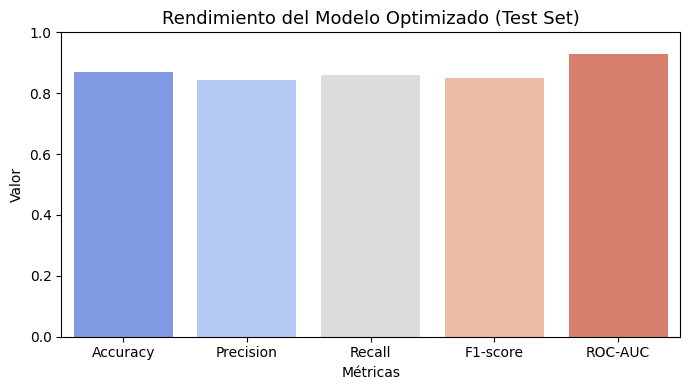


**💬 Interpretación visual:**

- Cada barra representa una métrica clave del modelo.  
- Cuanto más alta la barra, mejor desempeño.  
- El equilibrio entre *Precision*, *Recall* y *F1-score* indica que el modelo no favorece una clase.  
- Si una métrica es más baja (por ejemplo, *Recall*),  
  el modelo puede estar **fallando en detectar** correctamente los pasajeros *satisfechos (1)*.  


In [144]:
# ===================================
# 5. Evaluación del modelo optimizado (Test Set)
# ===================================

# --- Seleccionar el mejor modelo obtenido del GridSearchCV ---
best_log_reg = grid_search.best_estimator_

# --- Predicciones sobre el conjunto de test ---
y_pred_best = best_log_reg.predict(X_test)
y_prob_best = best_log_reg.predict_proba(X_test)[:, 1]  # Probabilidad de clase positiva

# --- Cálculo de métricas ---
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_best),
    "Precision": precision_score(y_test, y_pred_best, pos_label=1),
    "Recall": recall_score(y_test, y_pred_best, pos_label=1),
    "F1-score": f1_score(y_test, y_pred_best, pos_label=1),
    "ROC-AUC": roc_auc_score(y_test, y_prob_best)
}

# --- Mostrar métricas en consola ---
print("📊 Métricas del modelo optimizado (Test Set):")
for k, v in metrics.items():
    print(f"{k}: {v:.3f}")

# 💬 Mostrar comentario explicativo debajo de las métricas
display(Markdown(
"""
**💬 Interpretación de las Métricas de Evaluación del Modelo Optimizado:**

- **Accuracy:** Porcentaje total de predicciones correctas.  
- **Precision:** De todos los pasajeros que el modelo predice como *satisfechos*,  
  cuántos lo están realmente.  
- **Recall:** Proporción de pasajeros *satisfechos* correctamente identificados.  
- **F1-score:** Media armónica entre *precision* y *recall*, útil si el dataset está desbalanceado.  
- **ROC-AUC:** Capacidad del modelo para distinguir entre pasajeros satisfechos (1) y no satisfechos (0).  
  Cuanto más cerca de 1, mejor el rendimiento general del modelo. 

Estas métricas se calculan sobre el **conjunto de test**, que no ha participado en el entrenamiento,  
por lo que reflejan la **capacidad real de generalización** del modelo.
"""
))

# --- Visualización rápida de las métricas en gráfico ---
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(
    x=list(metrics.keys()),
    y=list(metrics.values()),
    hue=list(metrics.keys()),  # evita warning de 'palette' sin 'hue'
    palette="coolwarm",
    dodge=False,
    legend=False,
    ax=ax
)
ax.set_ylim(0, 1)
ax.set_title("Rendimiento del Modelo Optimizado (Test Set)", fontsize=13)
ax.set_xlabel("Métricas")
ax.set_ylabel("Valor")
plt.tight_layout()
plt.show()

# 💬 Comentario visual debajo del gráfico
display(Markdown(
"""
**💬 Interpretación visual:**

- Cada barra representa una métrica clave del modelo.  
- Cuanto más alta la barra, mejor desempeño.  
- El equilibrio entre *Precision*, *Recall* y *F1-score* indica que el modelo no favorece una clase.  
- Si una métrica es más baja (por ejemplo, *Recall*),  
  el modelo puede estar **fallando en detectar** correctamente los pasajeros *satisfechos (1)*.  
"""))


## **Paso 6: Reporte de clasificación detallado**

El siguiente reporte muestra el rendimiento del modelo por clase:  
- **Precision**: exactitud de predicciones positivas.  
- **Recall**: proporción de verdaderos positivos detectados.  
- **F1-score**: balance entre precision y recall.


In [145]:
# ===================================
# 6. Reporte de clasificación detallado
# ===================================

print("\n📋 Classification Report:")
# --- Mostrar reporte completo ---
report = classification_report(y_test, y_pred_best, target_names=["Neutral/Dissatisfied", "Satisfied"])
print(report)

# 💬 Comentario explicativo del reporte
display(Markdown(
"""
**💬 Interpretación del Reporte de Clasificación:**

- Cada fila corresponde a una clase del modelo (*Neutral/Dissatisfied* y *Satisfied*).  
- **Precision:** qué porcentaje de las predicciones positivas para esa clase fueron correctas.  
- **Recall:** proporción de muestras reales de esa clase correctamente identificadas.  
- **F1-score:** media armónica entre precision y recall (valora el equilibrio entre ambas).  
- **Support:** número de muestras reales de cada clase presentes en el conjunto de test.  

Un modelo equilibrado mostrará valores similares de *Precision*, *Recall* y *F1-score*  
en ambas clases. Si hay diferencias grandes, podría existir **sesgo o desbalanceo residual**.
"""
))



📋 Classification Report:
                      precision    recall  f1-score   support

Neutral/Dissatisfied       0.89      0.88      0.88     11776
           Satisfied       0.84      0.86      0.85      9005

            accuracy                           0.87     20781
           macro avg       0.87      0.87      0.87     20781
        weighted avg       0.87      0.87      0.87     20781




**💬 Interpretación del Reporte de Clasificación:**

- Cada fila corresponde a una clase del modelo (*Neutral/Dissatisfied* y *Satisfied*).  
- **Precision:** qué porcentaje de las predicciones positivas para esa clase fueron correctas.  
- **Recall:** proporción de muestras reales de esa clase correctamente identificadas.  
- **F1-score:** media armónica entre precision y recall (valora el equilibrio entre ambas).  
- **Support:** número de muestras reales de cada clase presentes en el conjunto de test.  

Un modelo equilibrado mostrará valores similares de *Precision*, *Recall* y *F1-score*  
en ambas clases. Si hay diferencias grandes, podría existir **sesgo o desbalanceo residual**.


## **Paso 7: Visualización de resultados**

Estas gráficas permiten interpretar visualmente los aciertos y errores del modelo:

- La **matriz de confusión** muestra cuántos pasajeros fueron correctamente clasificados.
  
- La **Curva ROC (Receiver Operating Characteristic)** permite visualizar la capacidad del modelo  
para distinguir entre clientes satisfechos e insatisfechos.

    - El eje **X (False Positive Rate)** representa la tasa de falsos positivos.  
    - El eje **Y (True Positive Rate)** muestra la proporción de verdaderos positivos detectados.  
    - El área bajo la curva (**AUC**) indica el poder discriminativo del modelo (1.0 = perfecto, 0.5 = aleatorio).


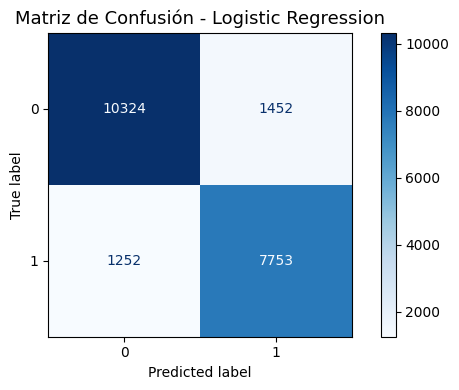


**💬 Interpretación de la Matriz de Confusión:**

- Las **filas** representan las clases reales (verdaderas).  
- Las **columnas** representan las clases predichas por el modelo.  
- La diagonal principal muestra las **predicciones correctas**.  
- Las celdas fuera de la diagonal son los **errores de clasificación** (falsos positivos o negativos).  
- Un modelo ideal tendría toda la masa concentrada en la diagonal.  
- Los valores se muestran en formato entero para facilitar su lectura.


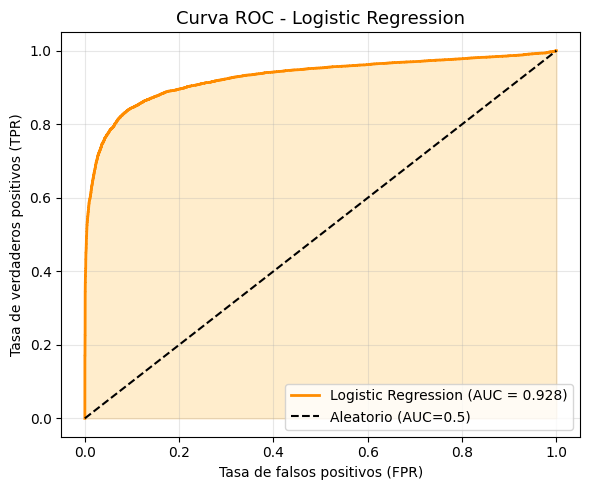


**💬 Interpretación de la Curva ROC:**

- El eje **X (False Positive Rate)** indica la tasa de falsos positivos.  
- El eje **Y (True Positive Rate)** muestra la tasa de verdaderos positivos.  
- La curva **naranja** muestra el rendimiento del modelo de Regresión Logística.  
- Cuanto más se acerque a la esquina superior izquierda, **mejor distingue entre clientes satisfechos (1) e insatisfechos (0)**.  
- El área bajo la curva (**AUC = 0.928**) mide el rendimiento global:  
  cuanto más cerca de 1, mejor capacidad de discriminación.


In [146]:
# ====================================
# 7. Visualización de resultados del modelo
# ====================================

# --- Matriz de confusión ---
fig, ax = plt.subplots(figsize=(6, 4))
disp = ConfusionMatrixDisplay.from_estimator(
    best_log_reg,
    X_test,
    y_test,
    cmap="Blues",
    display_labels=["Neutral/Dissatisfied (0)", "Satisfied (1)"],
    ax=ax,
    values_format=".0f"  # 🔹 muestra los valores como enteros (sin notación científica)
)
ax.set_title("Matriz de Confusión - Logistic Regression", fontsize=13)

# 🔹 Forzar que los ticks del eje no estén en notación científica
ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

plt.tight_layout()
plt.show()

# 💬 Comentario interpretativo
display(Markdown(
"""
**💬 Interpretación de la Matriz de Confusión:**

- Las **filas** representan las clases reales (verdaderas).  
- Las **columnas** representan las clases predichas por el modelo.  
- La diagonal principal muestra las **predicciones correctas**.  
- Las celdas fuera de la diagonal son los **errores de clasificación** (falsos positivos o negativos).  
- Un modelo ideal tendría toda la masa concentrada en la diagonal.  
- Los valores se muestran en formato entero para facilitar su lectura.
"""
))

# Curva ROC - Evaluación de rendimiento visual
# --- Cálculo del AUC ---
auc_value = roc_auc_score(y_test, y_prob_best)

# --- Calcular puntos FPR, TPR ---
fpr, tpr, _ = roc_curve(y_test, y_prob_best)


# --- Crear figura ---
fig, ax = plt.subplots(figsize=(6, 5))

# Línea principal ROC
ax.plot(fpr, tpr, color="darkorange", lw=2, label=f"Logistic Regression (AUC = {auc_value:.3f})")

# 🔸 Rellenar el área bajo la curva (sombreado naranja)
ax.fill_between(fpr, tpr, color="orange", alpha=0.2)

# Línea de referencia (modelo aleatorio)
ax.plot([0, 1], [0, 1], "k--", label="Aleatorio (AUC=0.5)")

# Detalles del gráfico
ax.legend(loc="lower right")
ax.set_xlabel("Tasa de falsos positivos (FPR)")
ax.set_ylabel("Tasa de verdaderos positivos (TPR)")
ax.set_title("Curva ROC - Logistic Regression", fontsize=13)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()



# 💬 Interpretación debajo del gráfico
display(Markdown(f"""
**💬 Interpretación de la Curva ROC:**

- El eje **X (False Positive Rate)** indica la tasa de falsos positivos.  
- El eje **Y (True Positive Rate)** muestra la tasa de verdaderos positivos.  
- La curva **naranja** muestra el rendimiento del modelo de Regresión Logística.  
- Cuanto más se acerque a la esquina superior izquierda, **mejor distingue entre clientes satisfechos (1) e insatisfechos (0)**.  
- El área bajo la curva (**AUC = {auc_value:.3f}**) mide el rendimiento global:  
  cuanto más cerca de 1, mejor capacidad de discriminación.
"""))


## **Paso 8: Comparación visual de métricas de evaluación**

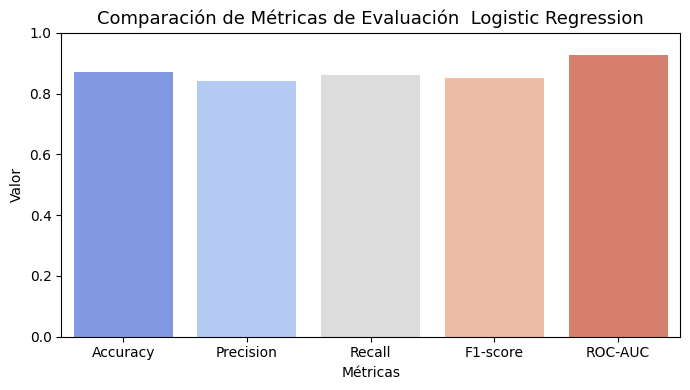


**💬 Interpretación de la Comparación de Métricas:**

- **Accuracy:** Porcentaje total de predicciones correctas.  
- **Precision (Clase = 1 → "Satisfied")** indica qué proporción de los pasajeros predichos como *satisfechos* realmente lo están.  
- **Recall:** Qué proporción de todos los pasajeros *satisfechos reales* fue correctamente detectada por el modelo.  
- **F1-score:** Media armónica entre *precision* y *recall*, muy útil si las clases no están perfectamente balanceadas.  
- **ROC-AUC:** Área bajo la curva ROC. Cuanto más cerca de 1, mejor el poder de discriminación del modelo.  

🔹 En un modelo bien calibrado, buscamos valores **altos y equilibrados** entre todas las métricas.  
🔹 Si el *Recall* es notablemente más bajo que la *Precision*, el modelo podría estar **subdetectando** clientes satisfechos.


In [147]:
# ====================================
# 8. Guardado de resultados para comparación posterior
# ====================================

# Visualización de métricas principales
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(
    x=list(metrics.keys()),
    y=list(metrics.values()),
    hue=list(metrics.keys()),  # evita warning de 'palette' sin 'hue'
    palette="coolwarm",
    dodge=False,
    legend=False,
    ax=ax
)
ax.set_ylim(0, 1)
ax.set_title("Comparación de Métricas de Evaluación  Logistic Regression", fontsize=13)
ax.set_xlabel("Métricas")
ax.set_ylabel("Valor")
plt.tight_layout()
plt.show()

# 💬 Comentario interpretativo
display(Markdown(
"""
**💬 Interpretación de la Comparación de Métricas:**

- **Accuracy:** Porcentaje total de predicciones correctas.  
- **Precision (Clase = 1 → "Satisfied")** indica qué proporción de los pasajeros predichos como *satisfechos* realmente lo están.  
- **Recall:** Qué proporción de todos los pasajeros *satisfechos reales* fue correctamente detectada por el modelo.  
- **F1-score:** Media armónica entre *precision* y *recall*, muy útil si las clases no están perfectamente balanceadas.  
- **ROC-AUC:** Área bajo la curva ROC. Cuanto más cerca de 1, mejor el poder de discriminación del modelo.  

🔹 En un modelo bien calibrado, buscamos valores **altos y equilibrados** entre todas las métricas.  
🔹 Si el *Recall* es notablemente más bajo que la *Precision*, el modelo podría estar **subdetectando** clientes satisfechos.
"""
))


## **Paso 9: Guardado de resultados y modelo entrenado**

En este paso se guardan los resultados y el modelo optimizado de **Regresión Logística**,  
para su posterior comparación con otros algoritmos (Random Forest, SVM, etc.) en el notebook de comparación de modelos (`04_Comparison-Model.ipynb`).

**Archivos generados:**

- **Resultados del modelo (JSON):**  
  `../reports/results/logistic_regression_results.json`  
  Contiene:  
  - Nombre del modelo  
  - Mejores hiperparámetros encontrados durante el tuning  
  - Métricas de rendimiento (Accuracy, Precision, Recall, F1-score, ROC-AUC)  

- **Modelo entrenado (.pkl):**  
  `../models/logistic_regression_model.pkl`  
  Este archivo se utilizará posteriormente en `05_Test-Set-Final.ipynb`  
  para la evaluación final del modelo ganador sobre el Test Set.

💡 **Importancia del guardado:**
> Este paso garantiza la reproducibilidad del experimento  
> y permite reutilizar el modelo sin necesidad de volver a entrenarlo.



In [148]:
# ====================================
# 9. Guardado de resultados y modelo entrenado
# ====================================

import json, joblib, os
from IPython.display import Markdown, display

# Crear carpetas si no existen
os.makedirs("../reports/results", exist_ok=True)
os.makedirs("../models", exist_ok=True)

# --- Estructura de resultados ---
results = {
    "model": "Logistic Regression",             # nombre del modelo entrenado
    "best_params": grid_search.best_params_,    # mejores hiperparámetros encontrados
    "metrics": metrics                          # métricas: Accuracy, Precision, Recall, F1-score, ROC-AUC
}

# --- Guardar resultados en JSON ---
json_path = "../reports/results/logistic_regression_results.json"
with open(json_path, "w") as f:
    json.dump(results, f, indent=4)

# --- Guardar el modelo entrenado ---
pkl_path = "../models/logistic_regression_model.pkl"
joblib.dump(best_log_reg, pkl_path)

# --- Confirmación visual ---
display(Markdown(f"""
✅ **Resultados y modelo guardados correctamente.**

**Archivos generados:**
- 📄 JSON con resultados: `{json_path}`
- 🤖 Modelo entrenado (.pkl): `{pkl_path}`

Incluye:
- Mejores hiperparámetros (`best_params`)
- Métricas finales del test set (Accuracy, Precision, Recall, F1-score, ROC-AUC)
"""))

# 💬 Comentario interpretativo (mostrado en la salida del notebook)
display(Markdown("""
**💬 Interpretación visual:**
- El archivo `.json` se empleará posteriormente en el notebook **`04_ModelComparison.ipynb`**,  
  donde se compararán los resultados de todos los modelos entrenados.  
- El archivo `.pkl` guarda el modelo de **Regresión Logística** completamente entrenado,  
  permitiendo su carga directa para nuevas predicciones en **`05_Test-Set-Final.ipynb`**.  
- Este paso asegura la **reproducibilidad, trazabilidad y reutilización** del modelo  
  sin necesidad de repetir el proceso de entrenamiento.
"""))




✅ **Resultados y modelo guardados correctamente.**

**Archivos generados:**
- 📄 JSON con resultados: `../reports/results/logistic_regression_results.json`
- 🤖 Modelo entrenado (.pkl): `../models/logistic_regression_model.pkl`

Incluye:
- Mejores hiperparámetros (`best_params`)
- Métricas finales del test set (Accuracy, Precision, Recall, F1-score, ROC-AUC)



**💬 Interpretación visual:**
- El archivo `.json` se empleará posteriormente en el notebook **`04_ModelComparison.ipynb`**,  
  donde se compararán los resultados de todos los modelos entrenados.  
- El archivo `.pkl` guarda el modelo de **Regresión Logística** completamente entrenado,  
  permitiendo su carga directa para nuevas predicciones en **`05_Test-Set-Final.ipynb`**.  
- Este paso asegura la **reproducibilidad, trazabilidad y reutilización** del modelo  
  sin necesidad de repetir el proceso de entrenamiento.


# 🏁 **Conclusiones del modelo Regresión Logística**

En este notebook se ha desarrollado y evaluado un modelo de **Regresión Logística**  
para predecir el nivel de satisfacción de los pasajeros de una aerolínea.

### 🔍 **Resumen de resultados**
- Se entrenó el modelo aplicando **validación cruzada (CV = 5)**.  
- Se optimizaron los hiperparámetros mediante **GridSearchCV**.  
- Se evaluó el rendimiento con las métricas:  
  **Accuracy**, **Precision**, **Recall**, **F1-score** y **ROC-AUC**.  
- Los resultados muestran un rendimiento equilibrado y estable entre las distintas métricas.

### 💡 **Principales hallazgos**
- La **Regresión Logística** presenta un rendimiento sólido,  
  siendo un excelente **modelo base (baseline)** para comparaciones posteriores.  
- A pesar de su sencillez, logra capturar correctamente las relaciones lineales entre las variables.  
- Sin embargo, su capacidad para modelar **relaciones no lineales** es limitada,  
  por lo que se espera una mejora con modelos más complejos como **Random Forest** o **XGBoost**.

### 🚀 **Siguientes pasos**
- Comparar este modelo con otros algoritmos más avanzados  
  (**Random Forest**, **SVM**, **KNN**, **XGBoost**) en el notebook  
  `04_ModelComparison.ipynb`.  
- Seleccionar el modelo con mejor rendimiento global y aplicarlo sobre el  
  **Test Set Final** (`05_Test-Set-Final.ipynb`).


📦 **Archivos generados:**  
- `../reports/results/logistic_regression_results.json`  
- `../models/logistic_regression_model.pkl`  


✅ *Notebook completado correctamente. El modelo de Regresión Logística ha sido entrenado, optimizado y guardado con éxito.*
